In [1]:
from typing_extensions import Annotated, Literal
from pydantic import BaseModel

from langchain_core.messages import AIMessage, HumanMessage
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.types import Command

import vertexai
from langchain_google_vertexai import ChatVertexAI
from google.cloud.aiplatform_v1beta1.types import Tool as VertexTool

from IPython.display import display, Image

members = ["habits", "summaries", "alerts"]
options = members + ["FINISH"]

# Define the router schema with Pydantic BaseModel
class Router(BaseModel):
    """Worker to route to next. If no workers needed, route to FINISH."""
    # next: Literal[*options]
    next: str

# Define graph state
class State(MessagesState):
    next: str

# Define the nodes
def supervisor(state: State) -> Command[Literal[*members, "__end__"]]:
    print("outer loop: supervisor")

    llm = ChatVertexAI(model="gemini-2.0-flash", temperature=0)

    supervisor_prompt = (
               """
               <instructions>
               \nYour response will only be one of 4 options: 'FINISH', 'habits', 'summaries', or 'alerts'.
               \n\nFirst, determine if the human's query has already been answered.
               \nLook at the latest AIMessage 'content' to see if the human's query has been answered.
               \nIf the human's query was answered, respond 'FINISH'.
               \n'FINISH' will END the conversation. You must END the chat with the human at some point.
               \nIf the human's query has NOT been answered...
               \n\nDecide if the human is::
               \n(1) providing their health KPIs for custom workout routines and diet plans ('habits').
               \n(2) OR requesting a simplified summary of complex medical information ('summaries').
               \n(3) OR need to be alerted because of health risks based on their personal health data ('alerts').
               \n\nRemember, only output 'FINISH', 'habits', 'summaries', or 'alerts'.
               \n</instructions>
               """)

    messages = [
        {"role": "system", "content": supervisor_prompt},] + state.get("messages", [])
    
    resp = llm.with_structured_output(schema=Router).invoke(messages)
    value = resp.next
    messages = state.get("messages", []) + [AIMessage(content=value)]
    
    goto = value
    if value == "FINISH":
        goto = END

    # note how Command allows you to BOTH update the graph state AND route to the next node
    return Command(
        # this is the state update
        update={"messages": messages, "next": value},
        # this is a replacement for an edge
        goto=goto,
    )


def habits(state: State) -> Command[Literal["supervisor"]]:
    print("outer loop: habits")
    
    llm = ChatVertexAI(model="gemini-2.0-flash-thinking-exp-01-21")

    habits_prompt = (
               """
               <instructions>
               \nGenerate customized workout routines and meal plans based on the patient's health KPIs.
               \n</instructions>
               """)

    messages = [
        {"role": "system", "content": habits_prompt},] + state.get("messages", [])

    resp = llm.invoke(messages)
    print(resp)
    messages = state.get("messages", []) + [AIMessage(content=resp.content)]

    return Command(
        # this is the state update
        update={"messages": messages, "next": "supervisor"},
        # this is a replacement for an edge
        goto="supervisor",
    )

def summaries(state: State) -> Command[Literal["supervisor"]]:
    print("outer loop: summaries")
    
    llm = ChatVertexAI(model="gemini-2.0-flash")

    summaries_prompt = (
               """
               <instructions>
               \nSummarize complex medical information (e.g., from doctor's notes, research papers) into easy-to-understand language tailored to the patient's health literacy.
               \nAnswer patient questions about their conditions and treatments.
               \n</instructions>
               """)

    messages = [
        {"role": "system", "content": summaries_prompt},] + state.get("messages", [])

    resp = llm.invoke(messages, tools=[VertexTool(google_search={})],)
    print(resp)
    messages = state.get("messages", []) + [AIMessage(content=resp.content)]

    return Command(
        # this is the state update
        update={"messages": messages, "next": "supervisor"},
        # this is a replacement for an edge
        goto="supervisor",
    )

def alerts(state: State) -> Command[Literal["supervisor"]]:
    print("outer loop: alerts")
    
    llm = ChatVertexAI(model="gemini-2.0-flash-thinking-exp-01-21")

    alerts_prompt = (
               """
               <instructions>
               \nAnalyze patient health data and proactively identify potential health risks or deviations from their personalized plan.
               \nGenerate alerts and offer personalized recommendations for intervention.
               \n</instructions>
               """)

    messages = [
        {"role": "system", "content": alerts_prompt},] + state.get("messages", [])

    resp = llm.invoke(messages)
    print(resp)
    messages = state.get("messages", []) + [AIMessage(content=resp.content)]

    return Command(
        # this is the state update
        update={"messages": messages, "next": "supervisor"},
        # this is a replacement for an edge
        goto="supervisor",
    )

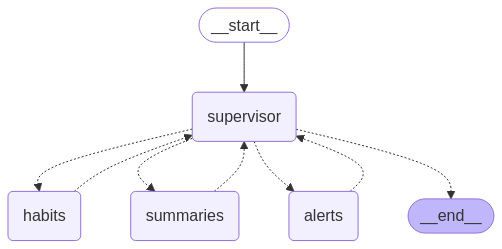

In [2]:
builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node(supervisor)
builder.add_node(habits)
builder.add_node(summaries)
builder.add_node(alerts)
# note: there are no edges between nodes A, B and C!
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
message = {"messages": HumanMessage(content="""[{
  "patient_id": "9",
  "age": "59",
  "gender": "Male",
  "race": "Black or African American",
  "occupation": "Bus Driver",
  "medical_conditions": "Sleep Apnea",
  "visit_date": "2024-02-28",
  "visit_reason": "Sleep study follow-up",
  "blood_pressure": "130/80",
  "heart_rate": "76",
  "blood_glucose": null,
  "respiratory_rate": "16",
  "oxygen_saturation": null,
  "total_cholesterol": null,
  "ldl_cholesterol": null,
  "smoker": "Yes",
  "drinker": "Light",
  "exercise": "Sedentary"
}]"""),}

chat_history = graph.invoke(message)